[[-13.79463493+0.00000000e+00j  -2.23081285+1.50386221e-17j
   10.0005695 +2.00102578e-16j ...  72.92576509+1.21084535e-14j
   83.63515515+1.82012948e-14j  87.67729254+2.14017882e-14j]
 [ 20.78502508+2.20050101e+00j  32.78293541+4.64509085e+00j
   44.55741748+5.95116900e+00j ...  44.16671884+1.63239220e-01j
   25.60549629-2.26396312e+00j   0.4154061 -4.00539108e+00j]
 [-12.27064528-3.26504558e+00j  -7.79398049+1.32884112e+01j
   -1.50482228+2.97446855e+01j ...  44.69059046+6.79395601e+01j
   54.68876694+6.02041360e+01j  59.3078548 +4.47842348e+01j]
 ...
 [  1.6047663 +9.53859048e+00j   5.36628471+2.15718423e+01j
    5.39949698+3.21664263e+01j ...  -8.64758793+4.96451981e+01j
   -7.59054393+3.78008393e+01j  -1.97136186+1.91454174e+01j]
 [-26.29389323-2.95339997e+00j -19.38849896-1.40638961e+01j
  -12.16964476-2.36683670e+01j ...  41.76381266-2.20493593e+01j
   54.62429815-7.74307388e+00j  62.96112063+9.32291862e+00j]
 [-16.89515827+2.16521986e+01j -25.6950685 +2.87685668e+01j
  -34.5431

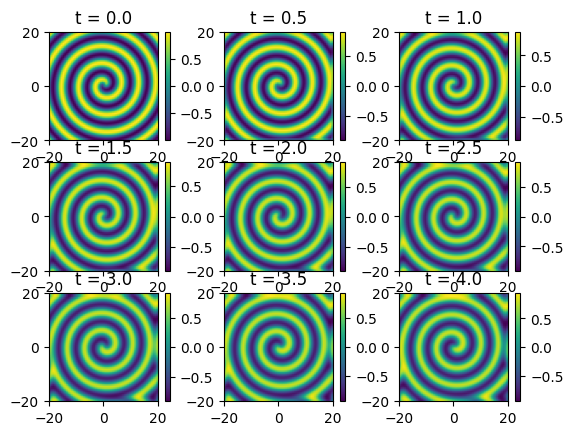

In [6]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2

# Reaction-diffusion parameters
D1 = D2 = 0.1
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny
beta = 1
tspan = (0, 4)
timesteps = np.arange(0, 4.5, 0.5)

#Spatial Domain
x2 = np.linspace(-Lx, Lx, nx+1)
x = x2[:nx]
y2 = np.linspace(-Ly, Ly, ny+1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)

#Spectral k
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

#calculate u and v
m = 1
u = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
v = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
ut = fft2(u)
vt = fft2(v)

uvt0 = np.hstack((ut.reshape(N), vt.reshape(N)))

#define pde
def spc_rhs(t, uvt, nx, ny, N, D1, D2, beta):
    utc = uvt[0:N]
    vtc = uvt[N:]
    ut = utc.reshape((nx, ny))
    vt = vtc.reshape((nx, ny))
    u = ifft2(ut)
    v = ifft2(vt)

    A = u*u + v*v
    Lambda = 1-A
    Omega = -beta*A

    rhs_u = (-D1 *K *ut + fft2( Lambda*u - Omega*v)).reshape(N)
    rhs_v = (-D2 *K *vt + fft2( Omega*u + Lambda*v)).reshape(N)

    return np.hstack([rhs_u, rhs_v])

uvtsol = solve_ivp(spc_rhs, tspan, uvt0, t_eval=timesteps, args=(nx, ny, N, D1, D2, beta))
A1 = uvtsol.y
print(A1)

for j, t in enumerate(timesteps):
    u = np.real(ifft2(A1[0:nx*ny, j].reshape((nx, ny))))
    plt.subplot(3, 3, j+1)
    plt.imshow(u, extent=(-Lx, Lx, -Ly, Ly), origin="lower", cmap="viridis")
    plt.colorbar()
    plt.title(f"t = {t}")

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.linalg import kron
from numpy import *

# Function to compute Chebyshev differentiation matrix
def cheb(N):
    if N == 0:
        D = 0.; x = 1.
    else:
        n = arange(0, N + 1)
        x = cos(pi * n / N).reshape(N + 1, 1)
        c = (hstack(([2.], ones(N - 1), [2.])) * (-1) ** n).reshape(N + 1, 1)
        X = tile(x, (1, N + 1))
        dX = X - X.T
        D = dot(c, 1. / c.T) / (dX + eye(N + 1))
        D -= diag(sum(D.T, axis=0))
    return D, x.reshape(N + 1)

# Reaction-diffusion parameters
D1 = D2 = 0.1
Lx, Ly = 20, 20  # Domain size
nx, ny = 30, 30  # Grid size
N = nx * ny
beta = 1
tspan = (0, 4)  # Time span
timesteps = np.arange(0, 4.5, 0.5)  # Time steps for evaluation

# Define the Chebyshev differentiation matrix and grid
N2 = (N + 1) * (N + 1)
D, x = cheb(N)

# Apply boundary conditions for Chebyshev nodes
D[N, :] = 0
D[0, :] = 0

# Define the Laplacian operator
Dxx = (np.dot(D, D)) / ((20 / 2) ** 2)  # Scaled Laplacian
Dyy = (np.dot(D, D)) / ((20 / 2) ** 2)

# Create the Laplacian operator using Kronecker product
I = np.eye(len(Dxx))
L = kron(I, Dxx) + kron(Dyy, I)

# Create the spatial domain using Chebyshev nodes
x, y = np.meshgrid(x, x)  # Mesh grid for X and Y
X = x * (20 / 2)  # Scale X and Y to domain size
Y = y * (20 / 2)

# Initial conditions for U and V
m = 1
u = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
v = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
uv0 = np.hstack((u.flatten(), v.flatten()))  # Flatten initial conditions

# Define the reaction-diffusion PDE system
def RD(t, uv, L, N2, N, D1, D2, beta):
    u = uv[:N2]
    v = uv[N2:]

    A = u**2 + v**2
    Lambda = 1 - A
    Omega = -beta * A

    rhs_u = D1 * np.dot(L, u) + Lambda * u - Omega * v
    rhs_v = D2 * np.dot(L, v) + Omega * u + Lambda * v

    return np.hstack((rhs_u, rhs_v))

# Solve the PDE using `solve_ivp`
uvtsol = solve_ivp(RD, tspan, uv0, t_eval=timesteps, args=(L, N, N2, D1, D2, beta))

# Extract the final solution
A2 = uvtsol.y[:, -1]  # Final solution at last time step
u_final = A2[:N].reshape((nx, ny))
v_final = A2[N:].reshape((nx, ny))

# Plot the final solution for U and V
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("U (Final solution - real space)")
plt.imshow(u_final, extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2), origin="lower", cmap="viridis")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("V (Final solution - real space)")
plt.imshow(v_final, extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2), origin="lower", cmap="viridis")
plt.colorbar()

plt.tight_layout()
plt.show()
